In [5]:
import numpy as np
import random,os,sys
import rasterio as rs
from rasterio.windows import Window,from_bounds
import geopandas as gpd

import matplotlib.pyplot as plt

In [6]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from tensorflow import keras
import tensorflow as tf

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
plt.style.use("bmh")

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[2:4], 'GPU')
logical_gpus = tf.config.list_logical_devices('GPU')
print(f'{len(gpus)}: Physical GPUs, {len(logical_gpus)}: Logical GPUs')

4: Physical GPUs, 2: Logical GPUs


In [75]:
class fetch_geom_batch(keras.utils.Sequence):
    
    def __init__(self,patches_path:str,feature_image_path:str, label_image_path:str, label:str, img_size:tuple, batch_size:int):
        
        self.patches_path = patches_path
        self.feature_image_path = feature_image_path
        self.label_image_path = label_image_path
        self.label = label
        self.batch_size = batch_size
        self.img_size = img_size
        
        self.patches = gpd.read_file(self.patches_path)
        self.patches_label = self.patches[self.patches['label'] == self.label]
        self.patches_label_shuffle = self.patches_label.sample(frac=1)
        
        
    def __len__(self):
        return len(self.patches_label) // self.batch_size
    
    def __getitem__(self,idx):
        
        i = idx * self.batch_size
        geom_patch_batch = self.patches_label_shuffle.iloc[i : i + self.batch_size]
        
        
        feat_img = rs.open(self.feature_image_path)
        label_img = rs.open(self.label_image_path)

        image = np.zeros((self.batch_size,) + self.img_size + (9,), dtype="float32") # number of channel should be changed
        label = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        
        for j, i in enumerate(range(len(geom_patch_batch))):
            minx,miny,maxx,maxy = geom_patch_batch.iloc[i, 3].bounds # Geometry column should be selected
            window_f = from_bounds(minx, miny, maxx, maxy, transform=feat_img.transform)
            window_l = from_bounds(minx, miny, maxx, maxy, transform=label_img.transform)
            transform = rs.transform.from_bounds(minx,miny,maxx,maxy, self.img_size[0], self.img_size[1])
            img_feat = np.moveaxis(feat_img.read(window=window_f,out_shape=self.img_size,resampling=0),0,2)
            img_label = np.moveaxis(label_img.read(window=window_l,out_shape=self.img_size,resampling=0),0,2)
            image[j] = img_feat
            label[j] = img_label
        
        return image,label

In [76]:
def plot_img(randomlist,dataset):
    for i in randomlist:
        fig = plt.figure(1, figsize=([12, 12]))
        gs = plt.GridSpec(1,4, wspace=0.25, hspace=0.25)

        img_id = i
        feat, label = dataset[img_id]

        # Panel 01
        xtr_subsplot= fig.add_subplot(gs[:,:1])
        plt.imshow(feat[1,...,0])
        plt.title('SAR_VV_Before')
        
        # Panel 02
        xtr_subsplot= fig.add_subplot(gs[:,1:2])
        plt.imshow(feat[1,...,2])
        plt.title('SAR_VV_After')

        # Panel 03
        xtr_subsplot= fig.add_subplot(gs[:,2:3])
        plt.imshow(label[1,...,0])
        plt.title('Label')


        # Panel 02
        xtr_subsplot= fig.add_subplot(gs[:,3:])
        plt.imshow(feat[1,...,8])
        plt.title('Forest mask')


        plt.show()

In [77]:
BATCH_SIZE = 32
IMAGE_SHAPE = (64, 64)
patches_path = './processed_DATA/patches_train_test_validation.geojson'
feature_image_path = "./processed_DATA/features.tif"
label_image_path = "./processed_DATA/binrized_image.tif"

In [78]:
Train_data = fetch_geom_batch(patches_path,feature_image_path,label_image_path,label='train',img_size=IMAGE_SHAPE,batch_size=BATCH_SIZE)

In [79]:
randomlist = random.sample(range(0, len(Train_data)), 15)

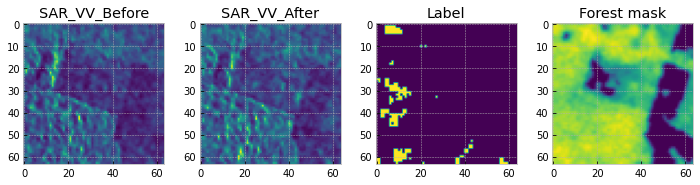

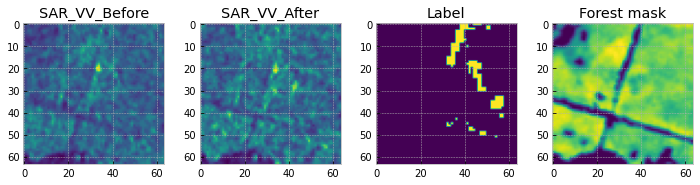

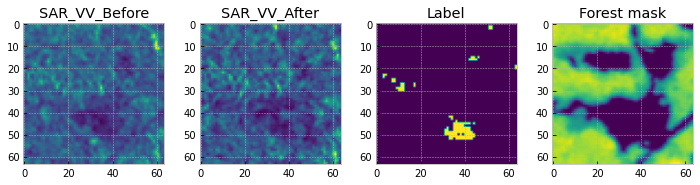

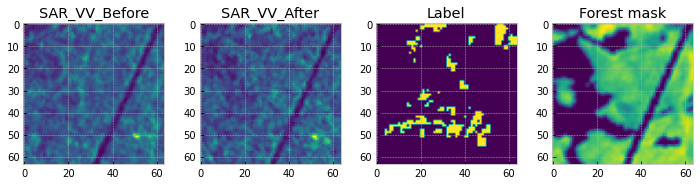

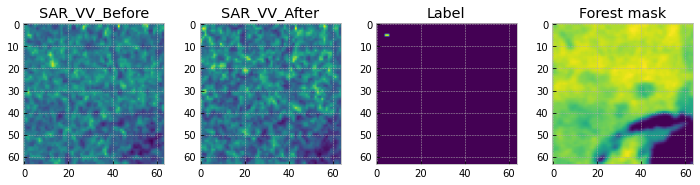

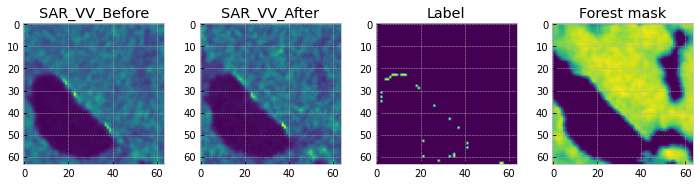

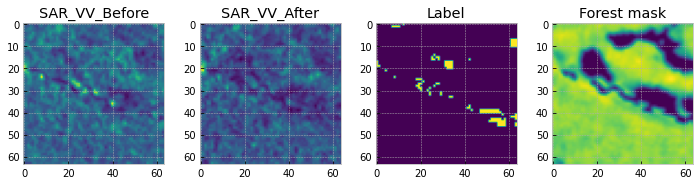

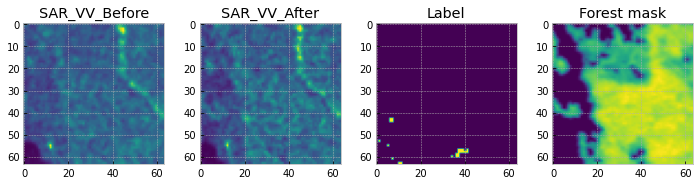

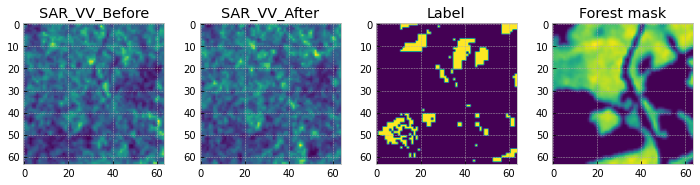

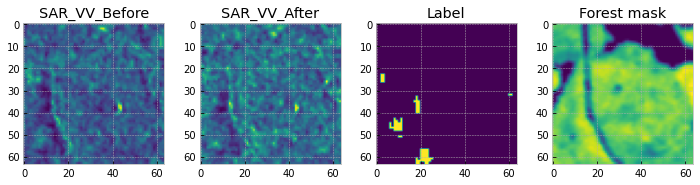

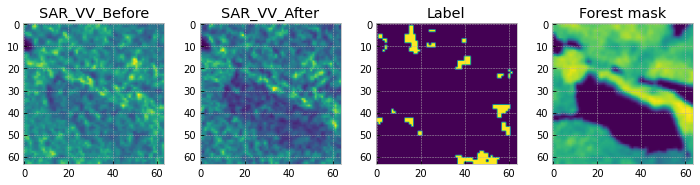

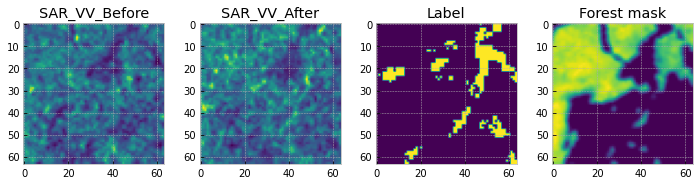

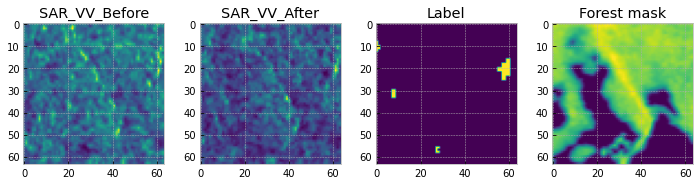

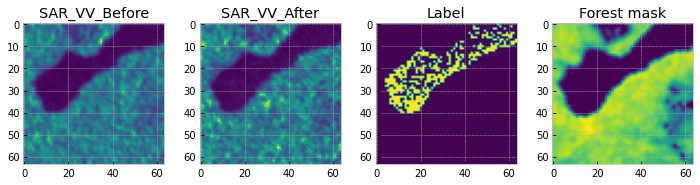

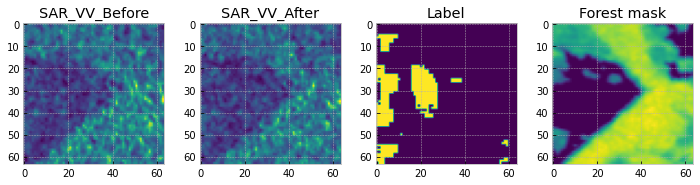

In [80]:
plot_img(randomlist,Train_data)

In [81]:
validation_data = fetch_geom_batch(patches_path,feature_image_path,label_image_path,label='validation',img_size=IMAGE_SHAPE,batch_size=BATCH_SIZE)

In [82]:
randomlist = random.sample(range(0, len(validation_data)), 15)

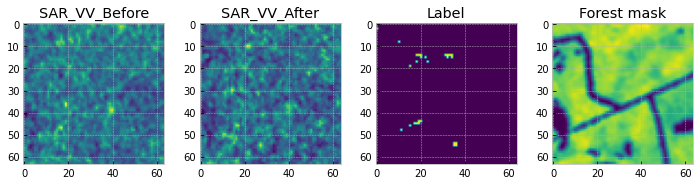

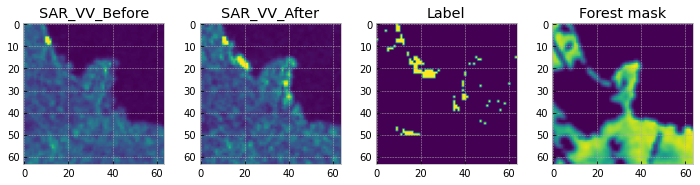

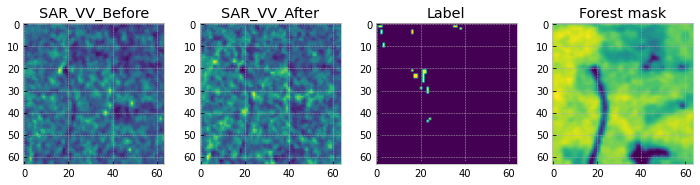

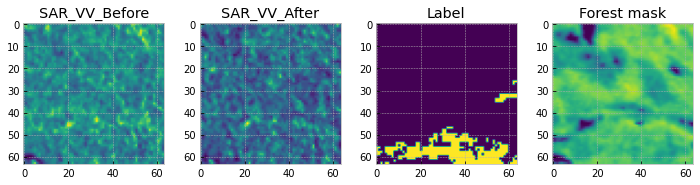

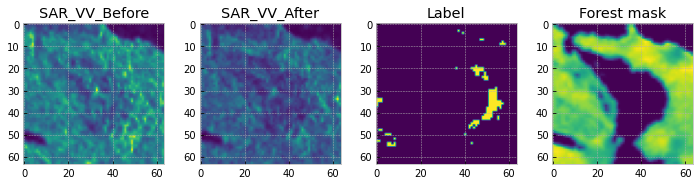

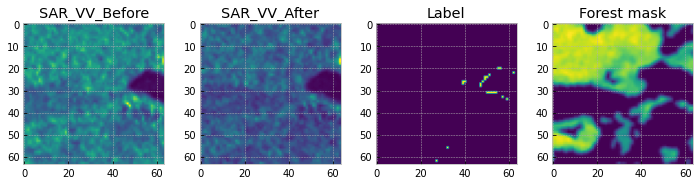

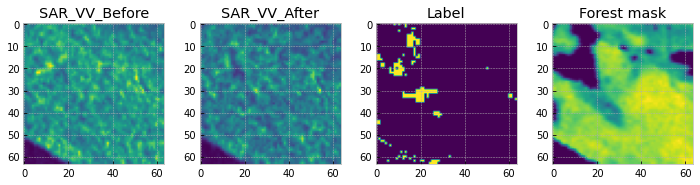

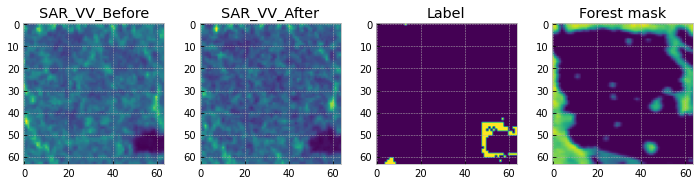

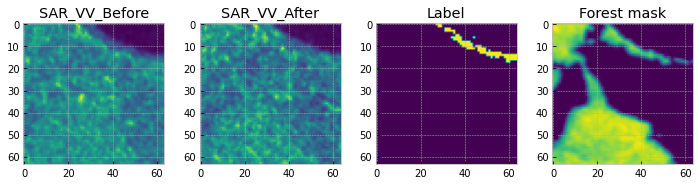

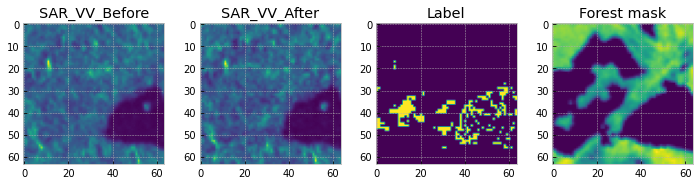

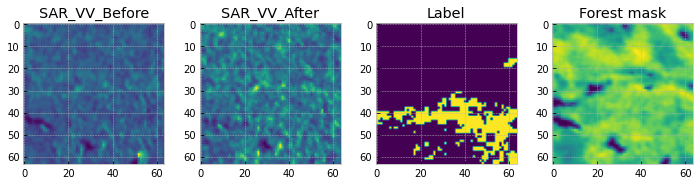

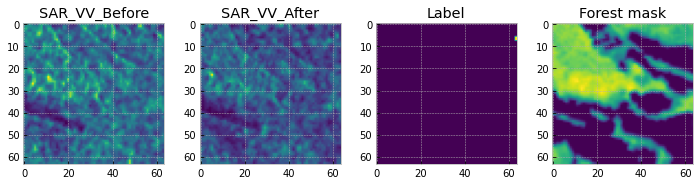

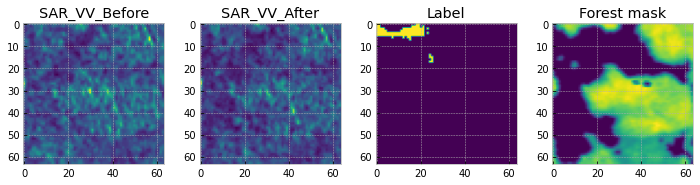

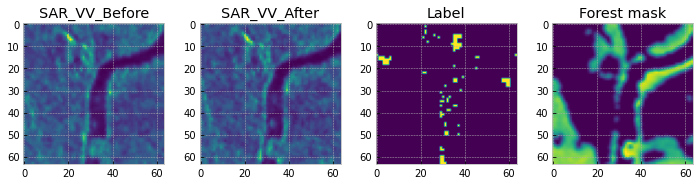

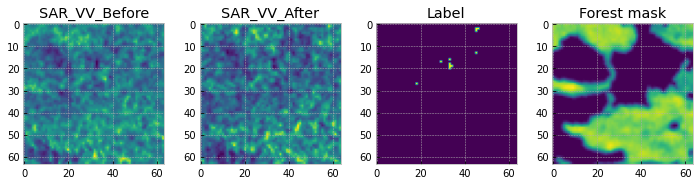

In [87]:
plot_img(randomlist,validation_data)

In [84]:
test_data = fetch_geom_batch(patches_path,feature_image_path,label_image_path,label='test',img_size=IMAGE_SHAPE,batch_size=BATCH_SIZE)

In [85]:
randomlist = random.sample(range(0, len(test_data)), 15)

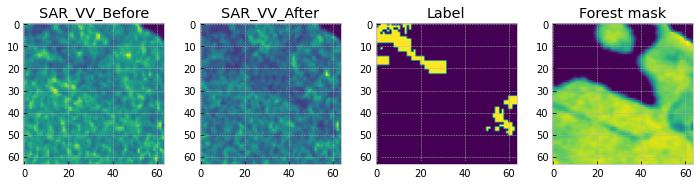

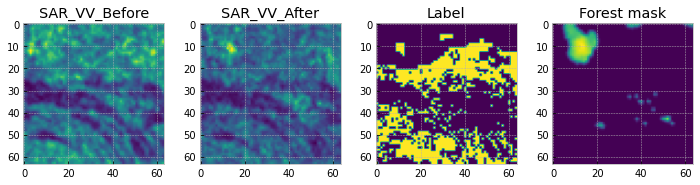

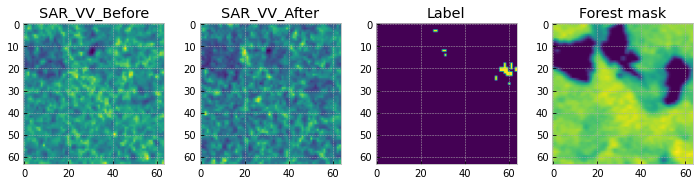

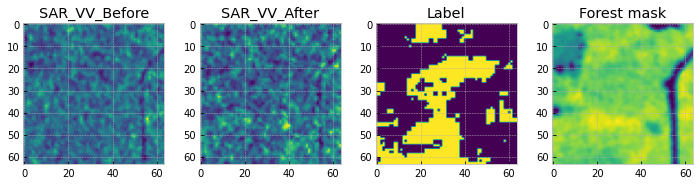

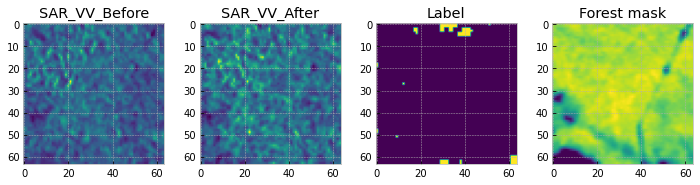

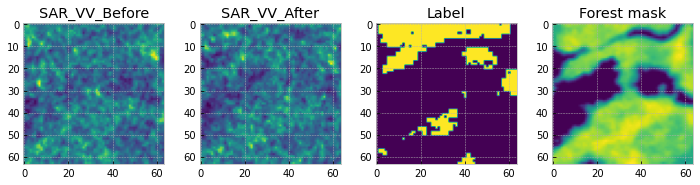

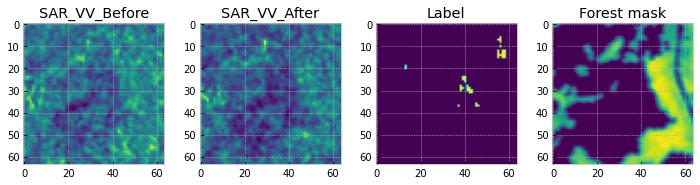

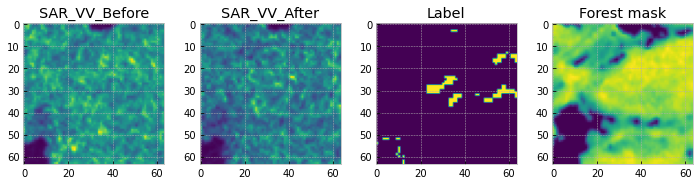

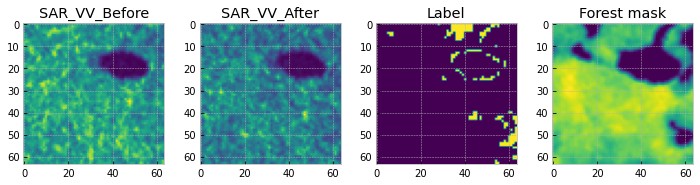

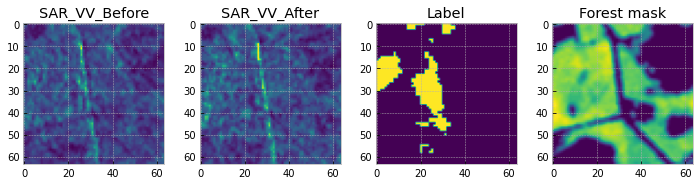

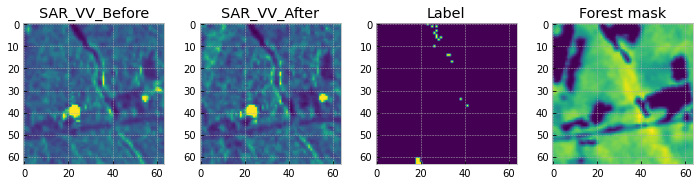

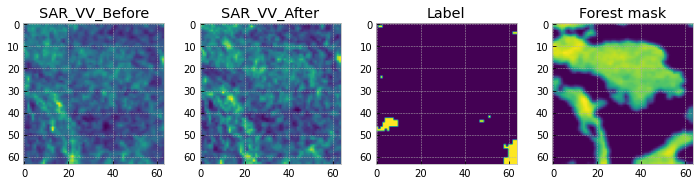

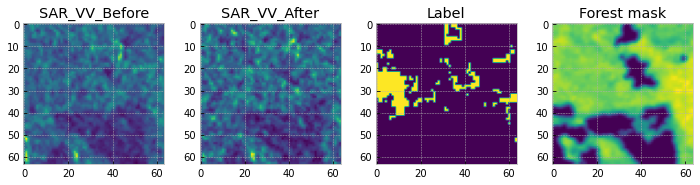

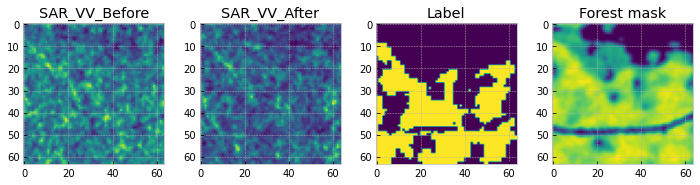

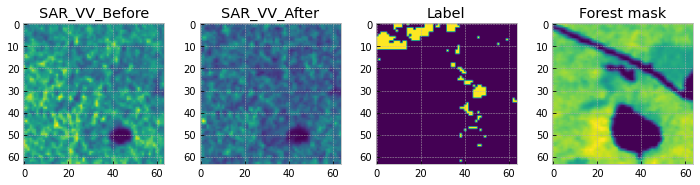

In [86]:
plot_img(randomlist,test_data)